In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from torch.nn import Parameter
from torch.nn.init import xavier_uniform_
import pandas as pd

# import utility code
import mrnn_utility
from mrnn_utility import block_diag,unblock_diag


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
# Generate the dummy dataset
np.random.seed(123)
f = np.array([1.5,2,2.5])
offset = np.array([0,1,2]).reshape(-1,1)
w = 2. * np.pi * f
t = np.linspace(0, 1, 50)
x = torch.tensor(np.sin(w.reshape(-1,1) * t)+offset).float()
ground_truth = x.detach().clone()
mask = torch.ones_like(x)
delta = torch.ones_like(x).float()
delta[:,0] = 0

# remove 5% of the data
ix = [(channel,t) for channel in range(x.shape[0]) for t in range(x.shape[1])]
np.random.shuffle(ix)
to_replace = int(round(.05*len(ix)))
ix = ix[:to_replace]
for idx in ix:
    x[idx[0],idx[1]] = np.nan
    mask[idx[0],idx[1]] = 0

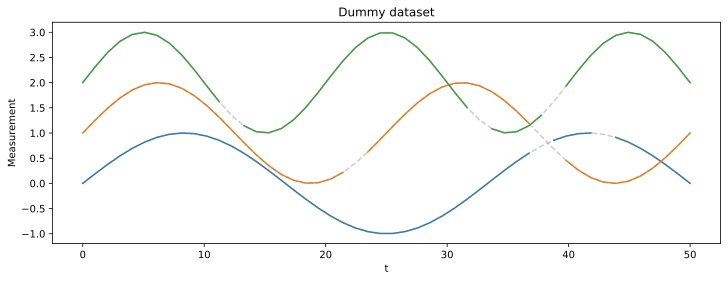

In [23]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12,4))
plt.title("Dummy dataset")
plt.xlabel("t")
plt.ylabel("Measurement")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),alpha=0.4,c="grey",linestyle='dashed')

In [24]:
hf_t12_d3 = np.array([2,4,3]) # Forward Hidden state of t-1

Wf3 = np.array([[ 0.1546, -0.6600,  0.5753],
        [-0.0077, -0.6195,  0.1414],
        [ 0.2404,  0.1764,  0.7104]]) # 3x3 weight matrix W^1
Vf3 = np.array([[-0.5855, -0.5765,  0.9371],
        [-0.5110,  0.3941,  0.5218],
        [-0.5413,  0.4935, -0.2625]]) # 3x3 weight matrix V^1
cf3 = np.array([-0.9524, -1.1768, -1.0417]) # 3x1 weight matrix V^1

hf_t13_d3 = mrnn_utility.ReLU(Wf3.dot(hf_t12_d3) + Vf3.dot(np.array([1.6247,1,1])) + cf3) # Calculate result

print(" The forward hidden state of t=13 and d=3 is: ",hf_t13_d3)

 The forward hidden state of t=13 and d=3 is:  [-0.         -0.          1.62744989]


In [25]:


hb_t13_d3 = np.array([-1,1.5,2.75]) # Backward Hidden state of t
U3 = np.array([ 0.2740,  0.6337,  0.8451, -1.1979,  0.4775, -0.4943]) # 1x6 Weight matrix U^1
c_3_0 = np.array([-0.2885]) # 1x1 bias c_0^1

x_tilde_t13_d3 = mrnn_utility.ReLU(U3.dot(np.concatenate((hf_t13_d3,hb_t13_d3))) + c_3_0) # compute result
print("Intermediate estimate for t=13 and d=3: ", x_tilde_t13_d3)



Intermediate estimate for t=13 and d=3:  [1.6416829]


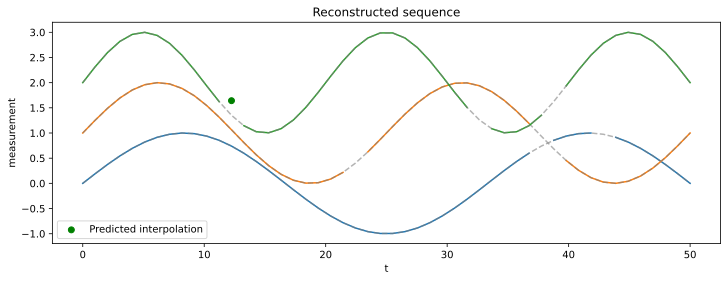

In [26]:
plt.figure(figsize=(12,4))
plt.title("Reconstructed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)
plt.scatter(t[12]*50,x_tilde_t13_d3,c="green",label="Predicted interpolation")
plt.legend()


In [27]:
class interpolater(nn.Module):
    '''Interpolater Module for the M-RNN model.'''
    def __init__(self,nchannels,hidden_dim,seq_len,padding="replication",act='relu'):
        super(interpolater, self).__init__()
        self.nchannels = nchannels
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        # Activation function
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        
        # Forward RNN weights
        self.Wf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Backward RNN weights
        self.Wb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Hidden state weights (combine forward and backward)
        self.U = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,1,hidden_dim*2).to(device=device))))
        self.c0 = Parameter(block_diag(nn.init.normal_(torch.FloatTensor(nchannels,1,1),std=.1).to(device=device)))
        
        # Padding options
        if padding == "replication":
            self.pad = nn.ReplicationPad2d((1,1,0,0))
        elif padding == "zero":
            self.pad = nn.ZeroPad2d((1,1,0,0))
            
    def forward(self,x,m,d):
        '''A forward pass through the interpolater. This function will go through all time steps.
        Input:
        x = Measurement
        m = Mask (1=observed, 0=missing)
        d = time elapsed since last observation
        
        Output:
        Estimate x_est for every input time step.'''
        
        batchsize = x.shape[0]
        # Initialize hidden states
        hidden_forwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        hidden_backwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        
        # Append zeros to beginning and end of input
        x = self.pad(x.unsqueeze(0)).squeeze(0)
        m = self.pad(m.unsqueeze(0)).squeeze(0)
        d = self.pad(d.unsqueeze(0)).squeeze(0)
        
        # Iterate through time (backward and forward)
        for t in range(self.seq_len):  
            # forward RNN hidden states
            hidden_f = self.act(torch.matmul(self.Wf,hidden_forwards[t]) + torch.matmul(self.Vf,
                block_diag(torch.stack((x[:,:,t],m[:,:,t],d[:,:,t]),axis=2).view(-1,self.nchannels,3,1))) 
                +self.cf)
            
            # backward RNN hidden states
            hidden_b = self.act(torch.matmul(self.Wb,hidden_backwards[t]) + 
                  torch.matmul(self.Vb,block_diag(torch.stack((x[:,:,self.seq_len+1-t],m[:,:,self.seq_len+1-t],
                  d[:,:,self.seq_len+1-t]),axis=2).view(-1,self.nchannels,3,1))) 
                  + self.cb)
            
            hidden_forwards.append(hidden_f)
            hidden_backwards.append(hidden_b)

        hidden_forwards = hidden_forwards[1:] # delete state t=-1
        hidden_backwards = hidden_backwards[1:][::-1] # delete state t=T+1 and reverse the list
        
        final_hidden=torch.empty(batchsize,self.nchannels,self.seq_len)
        
        # Iterate through time again and compute combined state
        for t in range(self.seq_len):
            hidden = self.act(torch.matmul(self.U,block_diag(torch.cat((
                unblock_diag(hidden_forwards[t],n=self.nchannels,size_block=(self.hidden_dim,1)),
                unblock_diag(hidden_backwards[t],n=self.nchannels,size_block=(self.hidden_dim,1))),axis=2))) 
                + self.c0)
            
            final_hidden[:,:,t]= unblock_diag(hidden,n=self.nchannels).flatten(1)
            
        return final_hidden


In [28]:
class imputer(nn.Module):
    '''Fully connected network that computes the imputation across data streams. We can use the time dimension
    as the batch dimension here, as the linear layers are independent of time.'''
    def __init__(self,n_channels,hidden_dim=3,act='relu'):
        super(imputer, self).__init__()
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        self.V1 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.V2 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.U = nn.Linear(n_channels,hidden_dim) # bias beta
        self.W = nn.Linear(hidden_dim,n_channels) # bias alpha
        
    def forward(self,x,x_est,m):
        '''x : true measurement
        x_est : estimated measurement of the interpolater
        m : mask'''
        v1out = self.V1(x_est.permute(0,2,1))
        v2out = self.V2(m.permute(0,2,1))
        self.U.weight.data.fill_diagonal_(0) # diagonal to zero to prevent usage of x_t^d at for prediction x_hat_t^d
        uout = self.U(x.permute(0,2,1)) 
        h = self.act(uout+v1out+v2out) # hidden layer
        out = self.W(h) # output layer, linear activation here
        return out.permute(0,2,1)



In [31]:
def lin_interpolation(x_in):
    x = x_in.clone()
    for sample in range(x.shape[0]): # for every sample
        for stream in range(x.shape[1]): # for every stream
            s = pd.Series(x[sample,stream])
            s = s.interpolate().bfill().ffill() # linear interpolation, then backward and forward fill for first and last value
            x[sample,stream] = torch.tensor(s.values) # replace in original tensor
    return x

In [171]:
class MRNN(nn.Module):
    def __init__(self,nchannels,seq_len,hidden_dim_inter,hidden_dim_imp=3,verbose=False,padding="replication",act='relu'):
        super(MRNN, self).__init__()
        self.inter = interpolater(nchannels,hidden_dim_inter,seq_len,padding=padding,act=act)
        self.imp = imputer(nchannels,hidden_dim_imp,act=act)
        self.verbose = verbose
        
    def forward(self,x,m,d):
        '''x = measurements, m = mask, d = time delta between measurements'''
        out = self.inter.forward(x,m,d)
        out = self.imp.forward(x,out,m)
        return out
    
    def fit(self,epochs,optimizer,loss_func,batch_size,x,m,d):
        loss_hist = []
        # Make initial interpolation
        x = lin_interpolation(x)

        # Iterate over epochs
        pbar = tqdm(range(epochs))
        for i in pbar:   
            # shuffle dataset
            indices = torch.randperm(x.shape[0])
            x = x[indices]
            m = m[indices]
            d = d[indices]
            
            temp_loss_hist=[]
            # Iterate over all batches
            for batch in range(int(x.shape[0] / batch_size)):
                x_b = x[batch*batch_size:(batch+1)*batch_size]
                m_b = m[batch*batch_size:(batch+1)*batch_size]
                d_b = d[batch*batch_size:(batch+1)*batch_size]
                # Estimate all values (forward pass)
                output = self.forward(x_b,m_b,d_b)
                # Compute loss
                loss = loss_func(m_b*output,m_b*x_b) # only use loss of actually observed measurements
                # Backward the loss
                optimizer.zero_grad()
                loss.backward()
                temp_loss_hist.append(loss)
                # Update the weights
                optimizer.step()
            if self.verbose:
                # print graph
                x_hat = self.predict(x,m,d)
                missing = (m!=1)
                mrnn_utility.live_plot(x_hat[0],missing[0],x[0],title=i)
                
            if temp_loss_hist:
                loss_hist.append(torch.stack(temp_loss_hist).mean())
            pbar.set_postfix({'loss': torch.stack(temp_loss_hist).mean()})
             
        return loss_hist
    
    def predict(self,x,m,d,replace=False):
        with torch.no_grad():
            # initial interpolation
            x = lin_interpolation(x)
            # Forward dataset
            out = self.forward(x,m,d)
            if replace:
                observed = (m==1)
                out[observed] = x[observed]
                
        return out     

In [172]:
torch.manual_seed(7)
dummy_model = MRNN(3,50,32,32,verbose=True,act='tanh')
dummy_optimizer = torch.optim.Adam(dummy_model.parameters(),lr=0.06)
loss_func = nn.MSELoss()
epochs = 10

In [173]:
x_t = x.unsqueeze(0).float().to(device=device)
m_t = mask.unsqueeze(0).float().to(device=device)
d_t = delta.unsqueeze(0).float().to(device=device)

In [174]:
mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [37]:
d_t

tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

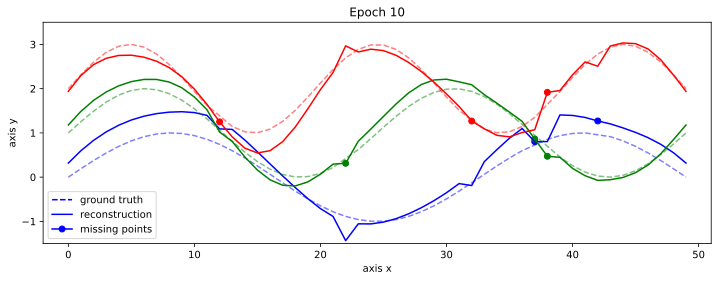

In [38]:
losses = dummy_model.fit(epochs,dummy_optimizer,loss_func,1,x_t,m_t,d_t) # start interactive training

In [39]:


x_hat = dummy_model.predict(x_t,m_t,d_t,replace=True)



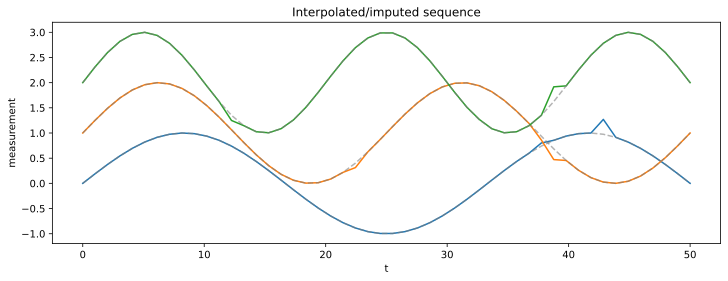

In [40]:
plt.figure(figsize=(12,4))
plt.title("Interpolated/imputed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x_hat[0][i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)

In [45]:
from scipy.io import arff

In [188]:
data = pd.read_csv('data/vazoes_CA_20_23.csv')

In [189]:
data = np.array((data['Vazao1_CA_1d'].to_numpy(), data['Vazao2_CA_1d'].to_numpy()))

In [190]:
data[:,20:40]

array([[55., 51., 47., 46., 58., 73., 70., 82., 84., 91., 73., 58., 50.,
        45., 41., 38., 35., 32., 30., 27.],
       [55., 51., 47., 46., 58., 73., 70., 82., 84., 91., 73., 58., 50.,
        45., 41., 38., 35., 32., 30., 27.]])

In [191]:
nchunks = 10
chunksize = int(data.shape[1] / nchunks)
chunked=[data[:,chunksize*i:chunksize*(i+1)] for i in range(nchunks)]
data = torch.tensor(np.array(chunked)).float()#.cuda() when on GPU

In [192]:
print("Number of samples: ",data.shape[0])
print("Number of channels: ",data.shape[1])
print("Length of time sequence: ",data.shape[2])

Number of samples:  10
Number of channels:  2
Length of time sequence:  863


In [193]:
mask = torch.ones_like(data).float()
delta = torch.ones_like(data).float()
delta[:,:,0] = 0

In [194]:
eye_model = MRNN(4,74,32,32,verbose=False,padding="replication").to(device=device)
optimizer = torch.optim.Adam(eye_model.parameters(),lr=0.005)
loss_func = nn.MSELoss()
epochs = 50

In [196]:
losses = eye_model.fit(epochs,optimizer,loss_func,10,data,mask,delta)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (10) must match the size of tensor b (5) at non-singleton dimension 0

In [186]:
mask[1][1:18]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,